\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

## 1. {-}

Read in the data and drop the ```id``` and ```bond_id``` columns which clearly have no predictive power. Those columns that have "type" in the column name and the ```is_callable``` column are categorical variables which should be converted into dummy variables. Any other columns are on ratio scale. There are 46 of them. After the conversion, including the dummy variables, there are 81 predictors in the data (note that the response ```trade_price``` is also in the data now). 

In [1]:
import pandas as pd

data = pd.read_csv('bonddata.txt', sep=',').drop(['bond_id', 'id'], axis='columns')

# categorical
catCols = ['is_callable'] + [colName for colName in data.columns if 'type' in colName]    

# predictors on ratio scale
rsCols = [col for col in data.columns if col not in ['is_callable', 'trade_price'] and 'type' not in col]

data = pd.get_dummies(data=data, columns=catCols)

print(len(rsCols))
print(data.shape)

46
(1620, 82)


Below are the column names of all dummy variables. For each categorical variable in the original data, we will drop one column from the corresponding dummy variables representing the base case. Specifically, we will drop the ```is_callable_0``` column and any column whose column name ends with ```_2```. In addition, we add a ```constant``` column with value 1 for intercept in the regression. Now we have 70 predictors

In [2]:
print([col for col in data.columns if 'type' in col or 'is_callable' in col])

['is_callable_0', 'is_callable_1', 'trade_type_2', 'trade_type_3', 'trade_type_4', 'trade_type_last1_2', 'trade_type_last1_3', 'trade_type_last1_4', 'trade_type_last2_2', 'trade_type_last2_3', 'trade_type_last2_4', 'trade_type_last3_2', 'trade_type_last3_3', 'trade_type_last3_4', 'trade_type_last4_2', 'trade_type_last4_3', 'trade_type_last4_4', 'trade_type_last5_2', 'trade_type_last5_3', 'trade_type_last5_4', 'trade_type_last6_2', 'trade_type_last6_3', 'trade_type_last6_4', 'trade_type_last7_2', 'trade_type_last7_3', 'trade_type_last7_4', 'trade_type_last8_2', 'trade_type_last8_3', 'trade_type_last8_4', 'trade_type_last9_2', 'trade_type_last9_3', 'trade_type_last9_4', 'trade_type_last10_2', 'trade_type_last10_3', 'trade_type_last10_4']


In [3]:
data = data.drop([col for col in data.columns if col=='is_callable_0' or '_2' in col], axis='columns')
data['constant'] = 1
data.shape

(1620, 71)

There are 46 predictors on ratio scale. Below we plot the histogram for the first few. The skewness for some of the variables is clear

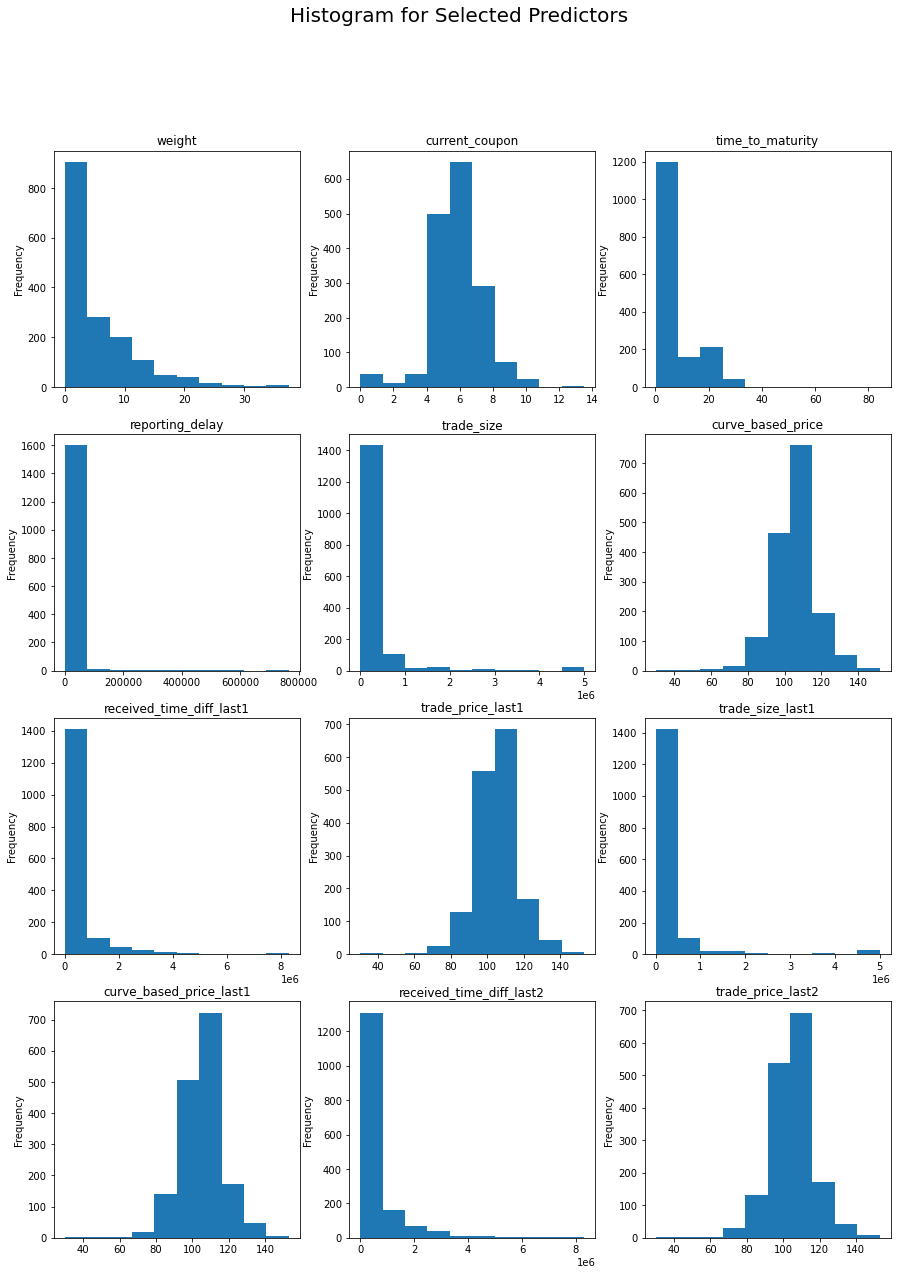

In [4]:
import matplotlib.pyplot as plt

def histplotGrid(suptitle):
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(suptitle, size=20)

    for col, ax in zip(rsCols[:12], axs.flatten()):
        data[col].plot(kind='hist', ax=ax)
        ax.set_title(col)
        
histplotGrid('Histogram for Selected Predictors')

We then apply the Yeo-Johnson transformation to each of those 46 predictors. The ```trade_size``` columns and the ```received_time_diff``` columns have large values so a $\log(1+x)$ transformation is applied beforehand. 

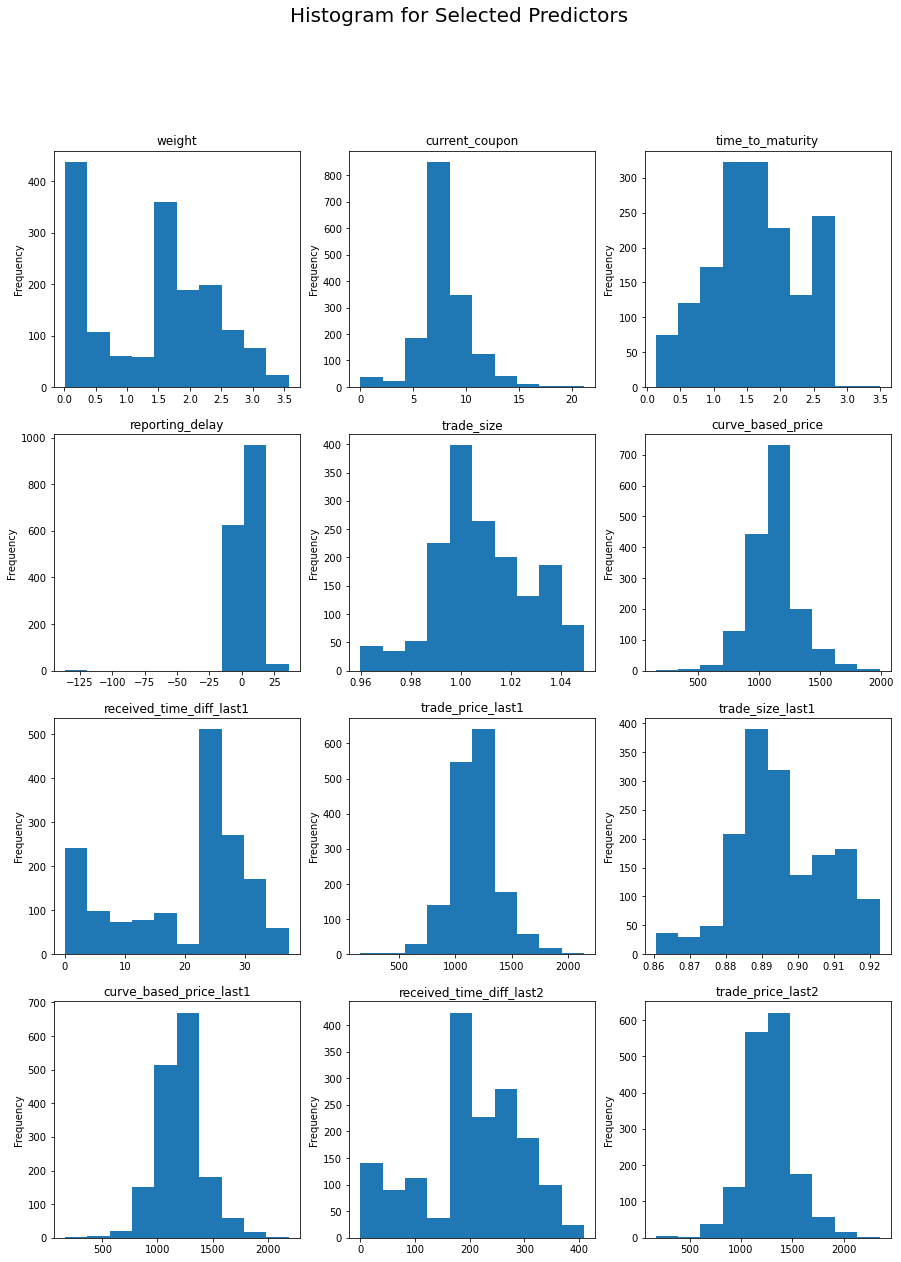

In [5]:
from scipy import stats
import numpy as np

lambdaDict = {}
for col in rsCols:
    if 'received_time_diff' in col or 'trade_size' in col:
        data[col] = np.log(data[col] + 1)
    data[col], lambdaDict[col] = stats.yeojohnson(data[col])

histplotGrid('Histogram for Selected Predictors After the Yeo-Johnson Transformation')